# Lesson 1: Image Recognition

In this lesson, we will (1) learn how to use a pre-trained VGG model (a deep convolutional network developed and trained by Oxford’s Visual Geometry Group) to classify images of cats and dogs and (2) build a VGG model from scratch in Keras. The course’s top-down approach starts with this lesson: using an existing deep learning model on a sorted data set without an in depth understanding of the model architecture. 

## Relaunching GPU Instances

In the previous lesson, we learned how to start an AWS instance. Now, we would like to relaunch an instance using aliases. First, load all aliases in the command prompt:
<br><br>
```source documents/courses-master/setup/aws-alias.sh```
<br><br>
So far, I’ve only launched a t2 instance. We will use our first alias ```aws-get-t2``` to let AWS know this is the instance we would like to restart. The function file returns the t2 instance ID. This is helpful to confirm which instance is being run. The same can be done with ```aws-get-p2```.
<br><br>
```aws-get-t2```
<br><br>
We can now start the instance:


```aws-start```

Which gives the following output:
<br><br>
```STARTINGINSTANCES       [insert ID here]
CURRENTSTATE       0    pending
PREVIOUSSTATE      80   stopped
[insert IP here]```
<br><br>
Notice the instance (confirmed with the instance ID) is running and queries for and prints out its attached elastic IP. We can now SSH back into our instance and set up a Jupyter Notebook on our server as we did in the previous lesson:
<br><br>
```aws-ssh```
<br><br>
Everything is now good to go; our python computing environment is ready. When you're done using your instance, use the alias ```aws-stop```.

## Building a Deep Learning Model

The standard practice of building a machine learning model is to split the given data into the following three subsets:
- **Training Sets**, which are used to fit parameters (labeled data).
- **Validation Sets**, which are used to finetune parameters (labeled data).
- **Test Sets**, which are used to predict unlabeled data.

Before we build our model, we should first organize our data sets. There are 25,000 labeled training images and 12,500 unlabeled test images of cats and dogs given for this competition. To copy these images from your computer to your virtual server, use:

```scp -r -i ~/.SSH/aws-key-fast-ai.pem $home/from/dir ubuntu@ec2-[insert IP here].us-west-2.compute.amazonaws.com:~/to/dir ```

Have your ```train```, ```valid```, and ```test``` folders nested under ```data``` and place all images in their respective folders. The validation set should contain a small portion of the given labeled data and should not be shared with the training set. Again, it's good practice to first work on a sample data set to get a basic process going on t2.micro before moving over to a full data set on p2.xlarge. 

## Building a Pre-Trained VGG Model

### Setting Up the Model

In this lesson, we will use a model that classifies images of dogs and cats for the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats) Kaggle competition. To start, here are a few configuration steps:

In [1]:
%matplotlib inline

This allows all plots to show inline in this notebook. Now, we can import a few basic libraries necessary for the execution of this notebook:

In [2]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

```Utils.py``` was created to store convenience functions. It's helpful to look through these functions in the file before implementing them. After importing ```utils```, we reload it to re-import the file so that the same model object can hold the results. 

In [3]:
import utils; reload(utils)
from utils import plots

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


### Using the Model

VGG 16 is a smaller and faster VGG model created by the VGG Imagenet team. For this competition, we will be using the course's given VGG16 python class for easier use of the VGG 16 model. As mentioned before, we won't go into the full mechanics of how this model works just yet; we just want a working model. 

In [4]:
# set the number of image samples to be trained at a time (should not exceed 64)
batch_size = 64

# define data path
path = "data/"

In [5]:
# import and instantiate vgg16 class
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [6]:
vgg = Vgg16()
# train and validate a few images at a time
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 635s - loss: 0.1154 - acc: 0.9685 - val_loss: 0.0533 - val_acc: 0.9800


These few lines of code can be used as a universal image recognition model for any number of categories as long as the data is sorted by category. After only one **epoch** (a full pass of the data through the model), a validation accuracy of 98% was achieved. 

We can see how this class works step by step by reviewing every line from the model above.
<br><br>
### Understanding the Model

The VGG16 class is used to categorize the main Imagenet category for each image in the data set. In Imagenet, cats and dogs are labeled by breed, not species (i.e. "cat" or "dog"). Before we get more into that, let's first create a VGG16 object. 

In [7]:
vgg = Vgg16()

VGG16 is run on top of Keras (a python-based deep learning library which is run on top of Theano or Tensorflow--other backend python-based deep learning libraries). Keras is able to read groups of images and labels in **batches** using a fixed directory structure. Batches are used to train our model at a faster rate without running out of memory. Let's grab these batches for our training set:

In [8]:
batches = vgg.get_batches(path+'train', batch_size=4)

Found 23000 images belonging to 2 classes.


Before continuing to build our model, it's important to understand how to view Imagenet predictions using this VGG16 class, so let's view some of our images and their labels below. The labels are actually arrays with values of either 1 or 0 in an ```[x. y.]``` format, where ```x ?= cat```, ```y ?= dog```. There are only two elements in these arrays because we're only predicting two categories (cats and dogs). Labeling/classifying data this way is popular in deep learning models and referred to as **one-hot encoding**.

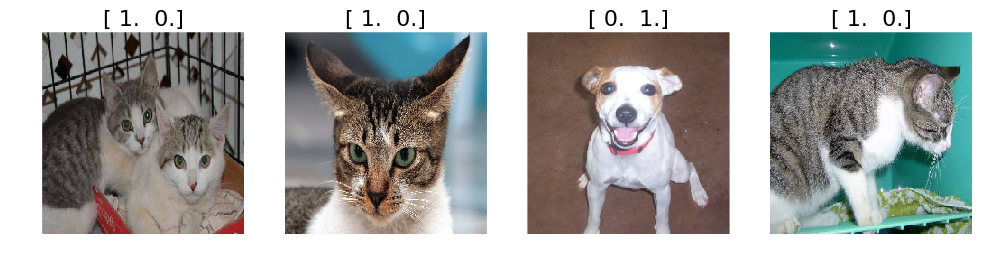

In [9]:
imgs,labels = next(batches)
plots(imgs, titles=labels)

We can now pass the images to VGG16's ```predict``` function to get back probabilities, category indexes (based on the ordering used in the VGG model), and category names for each image's VGG prediction. We can see that the images of these cats and dogs taken from Imagenet are in fact categorized by breed:

In [10]:
vgg.predict(imgs, True)

(array([ 0.722 ,  0.4632,  0.3093,  0.6466], dtype=float32),
 array([285, 285, 179, 281]),
 [u'Egyptian_cat', u'Egyptian_cat', u'Staffordshire_bullterrier', u'tabby'])

### Finetuning the Model

The model we're building should predict whether images contain either a cat or a dog. So far, we can use the model to predict the ~1,000 specific breeds of cats and dogs on Imagenet. In order to broaden our search to have our model only predict "cat" or "dog", we need to **finetune** the output. 

Finetuning is similar to what we've seen before: we use labeled images for training and a validation set for testing. The difference is that we're starting with a model that is already trained to make similar predictions. Using this model, we only need a subset of the original training data. This happens when you call the ```finetune``` function followed by ```fit```.

We begin with our training and validation sets. We double our batch size for our validation set because we don't need to backpropogate (discussed more in Lesson 2). So, increasing the validation batch size helps the model run faster.

In [11]:
batch_size=64
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Call ```finetune``` to have our model predict whether the images in these batches are either a cat or dog. Then, call ```fit``` to fit the parameters of the model to our training data for one epoch. 

In [12]:
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 634s - loss: 0.1199 - acc: 0.9685 - val_loss: 0.0576 - val_acc: 0.9820


Our image recognition model has now successfully used the VGG16 class to predict cats and dogs from our Imagenet data set. This exact model can be used for any other predictions, based on how you wish to categorize the data. Let's now build the model from scratch in Keras to better understand how the VGG16 class functions.  


## Recreating the VGG Model

### Setting Up the Model

We'll start by importing all the necessary modules from NumPy, SciPy, and Keras:

In [13]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

We also need to import the mappings from VGG IDs to Imagenet category IDs (category indexes and names) for display purposes later:

In [14]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

### Building the Model

I think it's helpful to include a quick summary of the VGG16 architecture before building it in Keras ourselves. Along with my brief explanation, I would recommend reading [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556), a paper published by members of VGG (an easy read). 

Here's a brief description of each layer in the model:

- The **Input Layer** is an image that traditionally has an RGB-depth of 3, where each pixel in the image at one of the three image channels relates to a distance between the image plane and the RGB image. 
- The **Convolutional Layer** is a compute-heavy linear operation. It takes in a bunch of filters (or weights) and applies them to an input image to create different activation features. The resulting dimensions of the output with respect to the input is the same except for the depth, which becomes the number of filters used. This layer is often followed by some type of non-linear activation layer (in this case, ReLU). 
- **ReLU** brings non-linearity to our network, which is needed to remove the possibility of overfitting our data (dicussed more in depth in [Lesson 3](https://github.com/fdaham/fastai/blob/master/lesson3.ipynb)).
- The **Pooling Layer** is another non-linear operation used for down-sizing data. It takes in the output from the previous Convolutional + ReLU Layers and returns either the max value (maxpooling) or average value of multi-dimensional inputs based on the stride size (in this case, 2x2). This effectively decreases the overall size of the subsequent layers (so for VGG16, because every 2x2 block is being replaced by one value, the overall layer's height and width are halved). In turn, this decreases the computational and spacial complexity of the network. 
- The **Fully Connected, or Dense, Layer** is a load-heavy linear operation where each input is connected to an output by a weight matrix. This layer is used to indentify the final output categories by combining patterns across each image. 
- The **Normalization Layer** (in this case, softmax) is the last layer which scales our input to return the final set of categories and their associated probabilities. 

Below is a graphical representation of the model, taken from [this blog](https://blog.heuritech.com/2016/02/29/a-brief-report-of-the-heuritech-deep-learning-meetup-5/). 

![Image](http://i.imgur.com/Tx8vfnO.png)

The VGG model has only one type of convolutional and fully connected layer (or block). Both are defined below.

In [15]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

For every layer in the convolutional block, rows and columns of zeros are added to the sides of the image tensor using ```ZeroPadding2D```, which takes in a tuple input of padding height and width: ```(symmetric_height_pad, symmetric_width_pad)```. This padding is used to ensure we convolve over the entire image. Then, we use ```Convolution2D```, which takes in the number of filters, kernel size (or the weights matrix created by the layer, where integer input indicates same height and width size), stride size, and activation as inputs. As mentioned above, the max pooling layer follows the convolutional layer to decrease the computational and spatial complexity of the model. ```MaxPooling2D``` takes the max pixel value in a 2x2 window with a stride size of 2. 

In [16]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

The fully connected block, like the convolutional layer, is followed by an element-wise activation function (in this case, ReLU). Keras' ```Dense``` layer implements the operation ```output = activation(dot(input, kernel) + bias)``` where ```bias``` is a bias vector created by the layer. The input units will become the dimension size (*, 4096).

When the VGG model was trained in 2014, the creators subtracted the average of each of the RGB channels first, so that the data for each channel had a zero mean. They also expected the channels to be in BGR order, but Python by default uses the RGB order. We need to make these two changes in order to pre-process our data and have it compatible with the VGG model:

In [17]:
# mean of each channel (by VGG researchers)
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse order from BGR to RGB

With all of our functions defined, we're ready to build our VGG16 model. We first use Keras' ```Sequential``` model, which is a linear stack of layers. ```Lambda``` is a Keras layer used to wrap an arbitrary expression as a layer object, which we use to pre-process the data (reverse BGR order to RBG and subtract the mean from each of the RGB channels for each pixel). We then convolve over our model five times using ```ConvBlock``` with 64 to 512 filters (see above image). 

After our model has passed these five convolutional layers (all followed by a pooling layer), we use Keras' ```Flatten``` layer to flatten the input. This needs to happen before passing our multidimensional input into the fully connected layer, where spatial structure doesn't matter. There are two fully connected layers with 4096 units each. The final layer is a softmax normalization layer with 1,000 units (representing the 1,000 ImageNet classes).

In [18]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

Now that the architecture is defined, let's create the model object:

In [19]:
model = VGG_16()

We're almost ready to use our VGG16 model, the only thing we're missing are the weights. Downloading pre-trained weights is preferred over training the model ourselves because downloading the entire Imagenet archive to train our model would take a few days (plus, it's already been done). Let's retrieve the pre-trained weights given for this model:

In [20]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

This concludes our model build. 

### Getting Predictions

To use our model, we first need a batch of images.

In [21]:
batch_size = 4

Keras has the ability to create batches of data from directories of images. To do this, you need to choose the desired size of the resized images, what type of labels to create, if you want to shuffle the images randomly, and the batch size. 

In [22]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

We can now use the same steps as before to look at the predictions from our model.

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


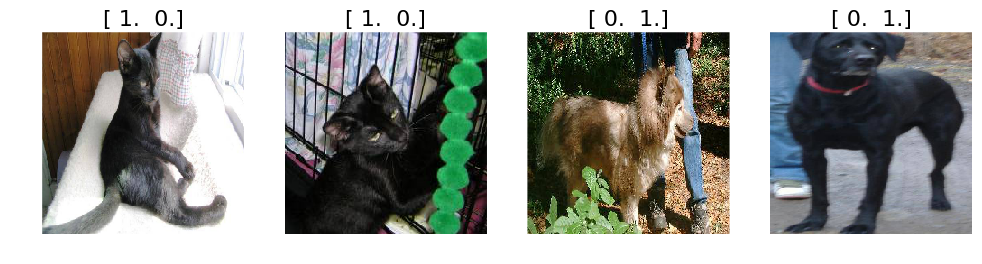

In [30]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)
plots(imgs, titles=labels)

We see that the batch of images above were correctly classified as either being a cat or dog (see one-hot encoding above image). Our VGG model returns 1,000 probabilities for each image. ```argmax``` returns the indexes with the largest probability, giving us the predicted labels.

In [28]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

Finally, we can see the breed probabilities for each of our four images below. The probabilities are low, but are a match, for the most part. 

In [31]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  5.1083e-07   1.8016e-07   2.7034e-06   2.6238e-06   3.2404e-05]

Predictions prob/class: 
  0.1593/Egyptian_cat
  0.7091/schipperke
  0.4026/Irish_wolfhound
  0.3274/Labrador_retriever
